In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

# Use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt

## Load Data

In [2]:
import cifar10

Set the path for storing the data-set on your computer.

The CIFAR-10 data-set is about 163 MB and will be downloaded automatically if it is not located in the given path.

In [3]:
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


Load the class-names.

In [4]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Load the training-set. This returns the images, the class-numbers as integers, and the class-numbers as One-Hot encoded arrays called labels.

In [5]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


Load the test-set.

In [6]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


The CIFAR-10 data-set has now been loaded and consists of 60,000 images and associated labels (i.e. classifications of the images). The data-set is split into 2 mutually exclusive sub-sets, the training-set and the test-set.

In [7]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Size of:
- Training-set:		50000
- Test-set:		10000


The data dimensions are used in several places in the source-code below. They have already been defined in the cifar10 module, so we just need to import them.

In [8]:
from cifar10 import img_size, num_channels, num_classes

The images are 32 x 32 pixels, but we will crop the images to 24 x 24 pixels.

In [9]:
img_size_cropped = 24

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [10]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

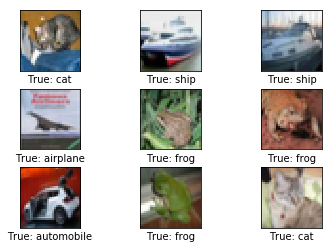

In [11]:
# Get the first images from the test-set.
images = images_test[0:9]

# Get the true classes for those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

The pixelated images above are what the neural network will get as input. The images might be a bit easier for the human eye to recognize if we smoothen the pixels.

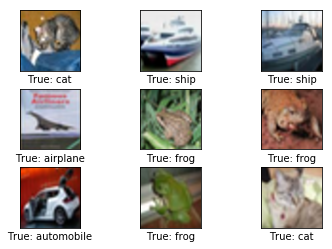

In [12]:
plot_images(images=images, cls_true=cls_true, smooth=True)

In [13]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')

In [14]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [15]:
y_true_cls = tf.argmax(y_true, dimension=1)

### Data augmentation for images

The following helper-functions create the part of the TensorFlow computational graph that pre-processes the input images. Nothing is actually calculated at this point, the function merely adds nodes to the computational graph for TensorFlow.

The pre-processing is different for training and testing of the neural network:
* For training, the input images are randomly cropped, randomly flipped horizontally, and the hue, contrast and saturation is adjusted with random values. This artificially inflates the size of the training-set by creating random variations of the original input images. Examples of distorted images are shown further below.

* For testing, the input images are cropped around the centre and nothing else is adjusted.

In [16]:
def pre_process_image(image, training):
    # This function takes a single image as input,
    # and a boolean whether to build the training or testing graph.
    
    if training:
        # For training, add the following to the TensorFlow graph.

        # Randomly crop the input image.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)
        
        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # Some of these functions may overflow and result in pixel
        # values beyond the [0, 1] range. It is unclear from the
        # documentation of TensorFlow whether this is
        # intended. A simple solution is to limit the range.

        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # For training, add the following to the TensorFlow graph.

        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

The function above is called for each image in the input batch using the following function.

In [17]:
def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

In order to plot the distorted images, we create the pre-processing graph for TensorFlow, so we may execute it later.

In [18]:
distorted_images = pre_process(images=x, training=True)

### Creating Main Processing

In [19]:
def main_network(images, training):
    # Wrap the input images as a Pretty Tensor object.
    x_pretty = pt.wrap(images)

    # Pretty Tensor uses special numbers to distinguish between
    # the training and testing phases.
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer

    # Create the convolutional neural network using Pretty Tensor.
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=64, name='layer_conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=64, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=256, name='layer_fc1').\
            fully_connected(size=128, name='layer_fc2').\
            softmax_classifier(num_classes=num_classes, labels=y_true)

    return y_pred, loss

In [20]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

In [21]:
def conv2d(x, W, name=None):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1],
                        padding='SAME', name=name)

def max_pool_3x3(x, name=None):
    return tf.nn.max_pool(x, ksize=[1, 3, 3, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME', name=name)

In [22]:
class AlexNet:
    
    @staticmethod
    def __create__placeholders__():
        with tf.name_scope("data"):           
            return tf.placeholder(tf.float32, name='keep_prob')
    
    @staticmethod
    def __conv2d__ (tensor, shape, filters, name):
        with tf.name_scope(name):
            weight = weight_variable(shape=[*shape, filters], name=name + '_weight_')
            bias   = bias_variable(shape=[filters], name=name + '_bias_')
            return tf.nn.relu(tf.add(conv2d(tensor, weight, name=name + '_conv2d_'), bias))
            
    @staticmethod
    def __max_pool__(tensor, name):
        with tf.name_scope(name):
            return max_pool_3x3(tensor, name=name + '_max_pool_')
    
    @staticmethod
    def __reshape_to(tensor, shape, name):
        with tf.name_scope(name):
            return tf.reshape(tensor, shape=[-1, shape], name=name + '_reshape_')
           
        
    @staticmethod
    def __fully_conn__(tensor, from_size, to_size, name):
        with tf.name_scope(name):
            weight = weight_variable(shape=[from_size, to_size], name=name + '_weight_')
            bias = bias_variable(shape=[to_size], name=name + '_bias_')
            return tf.nn.relu(tf.add( tf.matmul (tensor , weight), bias));
                
    @staticmethod
    def __last_layer__(tensor, from_size, to_size, name):
        with tf.name_scope(name):
            weight = weight_variable(shape=[from_size, to_size], name=name + '_weight_')
            bias = bias_variable(shape=[to_size], name=name + '_bias_')
            return  tf.add(tf.matmul( tensor , weight), bias)
    
    @staticmethod
    def __dropout__(tensor, keep_prob, name):
            return tf.nn.dropout(tensor, keep_prob=keep_prob, name=name + '_dropout_')
          
    @staticmethod
    def __loss__(y_true, logits):
        with tf.name_scope("loss"):
            return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits))
    
    @staticmethod
    def __part_1__(name, x):
        conv_1 = AlexNet.__conv2d__(tensor=x, shape=[5, 5, 3], filters=96, name='conv2d_1_' + name)
        pool_1 = AlexNet.__max_pool__(tensor=conv_1, name='max_pool_1_' + name)
        lrn_1  = tf.nn.local_response_normalization(pool_1)
        conv_2 = AlexNet.__conv2d__(tensor=lrn_1, shape=[4, 4, 96], filters=256, name='conv2d_2_' + name)
        pool_2 = AlexNet.__max_pool__(tensor=conv_2, name='max_pool_2')
        return tf.nn.local_response_normalization(pool_2)
    
    
    @staticmethod
    def __merge_1__(left, right, filters = 256, shape = [3, 3, 256]):
        conv2d_0_0 = AlexNet.__conv2d__(tensor=left, shape=shape, filters=filters, name='conv2d_3_0_0_')
        conv2d_0_1 = AlexNet.__conv2d__(tensor=left, shape=shape, filters=filters, name='conv2d_3_0_1_')
        conv2d_1_0 = AlexNet.__conv2d__(tensor=right, shape=shape, filters=filters, name='conv2d_3_1_0_')
        conv2d_1_1 = AlexNet.__conv2d__(tensor=right, shape=shape, filters=filters, name='conv2d_3_1_1')

        conv2d__left__= tf.add(conv2d_0_0, conv2d_1_0, name='__left__')
        conv2d__right__ = tf.add(conv2d_0_1, conv2d_1_1, name='__right__')
        
        return conv2d__left__, conv2d__right__
    
    @staticmethod
    def __part_2__(layer, name, filters = 256, shape=[3, 3, 256]):
        conv_4 = AlexNet.__conv2d__(tensor=layer, shape=shape,  filters=filters, name='conv2d_4_' + name)
        conv_5 = AlexNet.__conv2d__(tensor=conv_4, shape=shape, filters=filters, name='conv2d_5_' + name)
        pool_3 = AlexNet.__max_pool__(tensor=conv_5, name='_max_pool_3_' + name)
        return AlexNet.__reshape_to(tensor=pool_3, shape=2304, name='_reshape_' + name)
    
    
    @staticmethod
    def __logits__(left, right, from_size = 2304, to_size=2048, classes=10):        
        full_first_0_0 = AlexNet.__fully_conn__(tensor=left, from_size=from_size, to_size=to_size, name="__full__first_0_0") 
        full_first_0_1 = AlexNet.__fully_conn__(tensor=left, from_size=from_size, to_size=to_size, name="__full__first_0_1") 
        full_first_1_0 =  AlexNet.__fully_conn__(tensor=right, from_size=from_size, to_size=to_size, name="__full__first_1_0") 
        full_first_1_1 =  AlexNet.__fully_conn__(tensor=right, from_size=from_size, to_size=to_size, name="__full__first_1_1") 

        full_first_0 = tf.add(full_first_0_0, full_first_1_0, name='fc_first_0')
        full_first_1 = tf.add(full_first_0_1, full_first_1_1, name='fc_first_1')

        full_second_0_0 =  AlexNet.__fully_conn__(tensor=full_first_0, from_size=to_size, to_size=to_size, name="__full__second_0_0")  
        full_second_0_1 = AlexNet.__fully_conn__(tensor=full_first_0, from_size=to_size, to_size=to_size, name="__full__second_0_1")  
        full_second_1_0 = AlexNet.__fully_conn__(tensor=full_first_1, from_size=to_size, to_size=to_size, name="__full__second_1_0")  
        full_second_1_1 = AlexNet.__fully_conn__(tensor=full_first_1, from_size=to_size, to_size=to_size, name="__full__second_1_1")  

        full_second_0 = tf.add(full_first_0_0, full_first_1_0, name='fc_second_0')
        full_second_1 = tf.add(full_first_0_1, full_first_1_1, name='fc_second_1')
        
        logits_0 = AlexNet.__last_layer__(tensor=full_second_0,from_size=to_size, to_size=classes, name='logits_0')
        logits_1 = AlexNet.__last_layer__(tensor=full_second_1,from_size=to_size, to_size=classes, name='logits_1')
        
        return tf.add(logits_0, logits_1, name='final_logits')
  
    
    @staticmethod
    def create_network(x, y_true):
        AlexNet.__create__placeholders__()
        part1_0 = AlexNet.__part_1__(name='0',x=x)
        part1_1 = AlexNet.__part_1__(name='1', x=x)
        
        merge_0, merge_1 = AlexNet.__merge_1__(part1_0, part1_1)
        
        part2_0 = AlexNet.__part_2__(layer=merge_0, name='0')
        part2_1 = AlexNet.__part_2__(layer=merge_1, name='1')
        
        logits = AlexNet.__logits__(left=part2_0, right=part2_1)
        y_pred = tf.nn.softmax(_logits)
        loss = AlexNet.__loss__(y_true=y_true, logits=logits)
        
        return y_pred, loss
        
    

### Creating Neural Network

Note that the neural network is enclosed in the variable-scope named 'network'. This is because we are actually creating two neural networks in the TensorFlow graph. By assigning a variable-scope like this, we can re-use the variables for the two neural networks, so the variables that are optimized for the training-network are re-used for the other network that is used for testing.

In [23]:
def create_network(training):
    # Wrap the neural network in the scope named 'network'.
    # Create new variables during training, and re-use during testing.
    with tf.variable_scope('network', reuse=not training):
        # Just rename the input placeholder variable for convenience.
        images = x

        # Create TensorFlow graph for pre-processing.
        images = pre_process(images=images, training=training)

        # Create TensorFlow graph for the main processing.
#         y_pred, loss = main_network(images=images, training=training)
        
        y_pred, loss = AlexNet.create_network(images, y_true)

    return y_pred, loss

### Create Neural Network for Training Phase

Note that `trainable=False` which means that TensorFlow will not try to optimize this variable.

In [24]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

Create the neural network to be used for training. The `create_network()` function returns both `y_pred` and `loss`, but we only need the `loss`-function during training.

In [25]:
y_pred, loss = create_network(training=True)

Create an optimizer which will minimize the `loss`-function. Also pass the `global_step` variable to the optimizer so it will be increased by one after each iteration.

In [26]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)

### Create Neural Network for Test Phase / Inference

Now create the neural network for the test-phase. Once again the `create_network()` function returns the predicted class-labels `y_pred` for the input images, as well as the `loss`-function to be used during optimization. During testing we only need `y_pred`.

In [118]:
#y_pred, _ = create_network(training=False)

We then calculate the predicted class number as an integer. The output of the network `y_pred` is an array with 10 elements. The class number is the index of the largest element in the array.

In [27]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

Then we create a vector of booleans telling us whether the predicted class equals the true class of each image.

In [28]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

The classification accuracy is calculated by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then taking the average of these numbers.

In [29]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Saver

In order to save the variables of the neural network, so they can be reloaded quickly without having to train the network again, we now create a so-called Saver-object which is used for storing and retrieving all the variables of the TensorFlow graph. Nothing is actually saved at this point, which will be done further below.

In [30]:
saver = tf.train.Saver()

### Getting the Weights

Further below, we want to plot the weights of the neural network. When the network is constructed using Pretty Tensor, all the variables of the layers are created indirectly by Pretty Tensor. We therefore have to retrieve the variables from TensorFlow.

We used the names `layer_conv1` and `layer_conv2` for the two convolutional layers. These are also called variable scopes. Pretty Tensor automatically gives names to the variables it creates for each layer, so we can retrieve the weights for a layer using the layer's scope-name and the variable-name.

The implementation is somewhat awkward because we have to use the TensorFlow function `get_variable()` which was designed for another purpose; either creating a new variable or re-using an existing variable. The easiest thing is to make the following helper-function.

In [31]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'weights' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope("network/" + layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

Using this helper-function we can retrieve the variables. These are TensorFlow objects. In order to get the contents of the variables, you must do something like: `contents = session.run(weights_conv1)` as demonstrated further below.

In [124]:
#weights_conv1 = get_weights_variable(layer_name='layer_conv1')
#weights_conv2 = get_weights_variable(layer_name='layer_conv2')

In [125]:
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     print(sess.run(weights_conv1).shape)

In [126]:
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     print(sess.run(weights_conv2).shape)

### Getting the Layer Outputs

Similarly we also need to retrieve the outputs of the convolutional layers. The function for doing this is slightly different than the function above for getting the weights. Here we instead retrieve the last tensor that is output by the convolutional layer.

In [32]:
def get_layer_output(layer_name):
    # The name of the last operation of the convolutional layer.
    # This assumes you are using Relu as the activation-function.
    tensor_name = "network/" + layer_name + "/Relu:0"

    # Get the tensor with this name.
    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)

    return tensor

Get the output of the convoluational layers so we can plot them later.

In [128]:
#output_conv1 = get_layer_output(layer_name='layer_conv1')
#output_conv2 = get_layer_output(layer_name='layer_conv2')

## TensorFlow Run

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [33]:
session = tf.Session()

### Restore or initialize variables

Training this neural network may take a long time, especially if you do not have a GPU. We therefore save checkpoints during training so we can continue training at another time (e.g. during the night), and also for performing analysis later without having to train the neural network every time we want to use it.

If you want to restart the training of the neural network, you have to delete the checkpoints first.

This is the directory used for the checkpoints.

In [35]:
save_dir = 'checkpoints_AlexNet/'

Create the directory if it does not exist.

In [36]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

This is the base-filename for the checkpoints, TensorFlow will append the iteration number, etc.

In [37]:
save_path = os.path.join(save_dir, 'cifar10_AlexNet')

First try to restore the latest checkpoint. This may fail and raise an exception e.g. if such a checkpoint does not exist, or if you have changed the TensorFlow graph.

In [38]:
try:
    print("Trying to restore last checkpoint ...")

    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from None
Failed to restore checkpoint. Initializing variables instead.


### Helper-function to get a random training-batch

There are 50,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer.

If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to perform more optimization iterations.

In [39]:
train_batch_size = 64

Function for selecting a random batch of images from the training-set.

In [40]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(images_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

### Optimization

The progress is printed every 100 iterations. A checkpoint is saved every 1000 iterations and also after the last iteration.

In [55]:
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # We also want to retrieve the global_step counter.
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # Print status to screen every 100 iterations (and last).
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-batch.
            batch_acc, batch_loss = session.run([accuracy,loss],
                                    feed_dict=feed_dict_train)

            # Print status.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}, Loss: {2:.4f}"
            print(msg.format(i_global, batch_acc, batch_loss))

        # Save a checkpoint to disk every 1000 iterations (and last).
        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            # Save all variables of the TensorFlow graph to a
            # checkpoint. Append the global_step counter
            # to the filename so we save the last several checkpoints.
            saver.save(session,
                       save_path=save_path,
                       global_step=global_step)

            print("Saved checkpoint.")

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [42]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = images_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Plot confusion matrix

In [43]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

### Calculating classifications

This function calculates the predicted classes of images and also returns a boolean array whether the classification of each image is correct.

The calculation is done in batches because it might use too much RAM otherwise. If your computer crashes then you can try and lower the batch-size.

In [44]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(images, labels, cls_true):
    # Number of images.
    num_images = len(images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

Calculate the predicted class for the test-set.

In [45]:
def predict_cls_test():
    return predict_cls(images = images_test,
                       labels = labels_test,
                       cls_true = cls_test)

### Helper-functions for the classification accuracy

This function calculates the classification accuracy given a boolean array whether each image was correctly classified. E.g. `classification_accuracy([True, True, False, False, False]) = 2/5 = 0.4`. The function also returns the number of correct classifications.

In [46]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.
    
    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

### Helper-function for showing the performance

Function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

In [47]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

### Helper-function for plotting convolutional weights

In [48]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.

    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Print statistics for the weights.
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w.min(), w.max()))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # The format of this 4-dim tensor is determined by the
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=-abs_max, vmax=abs_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for plotting the output of convolutional layers

In [49]:
def plot_layer_output(layer_output, image):
    # Assume layer_output is a 4-dim tensor
    # e.g. output_conv1 or output_conv2.

    # Create a feed-dict which holds the single input image.
    # Note that TensorFlow needs a list of images,
    # so we just create a list with this one image.
    feed_dict = {x: [image]}
    
    # Retrieve the output of the layer after inputting this image.
    values = session.run(layer_output, feed_dict=feed_dict)

    # Get the lowest and highest values.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    values_min = np.min(values)
    values_max = np.max(values)

    # Number of image channels output by the conv. layer.
    num_images = values.shape[3]

    # Number of grid-cells to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_images))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid image-channels.
        if i<num_images:
            # Get the images for the i'th output channel.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, vmin=values_min, vmax=values_max,
                      interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Examples of distorted input images

In order to artificially inflate the number of images available for training, the neural network uses pre-processing with random distortions of the input images. This should hopefully make the neural network more flexible at recognizing and classifying images.

This is a helper-function for plotting distorted input images.

In [50]:
def plot_distorted_image(image, cls_true):
    # Repeat the input image 9 times.
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 9, axis=0)

    # Create a feed-dict for TensorFlow.
    feed_dict = {x: image_duplicates}

    # Calculate only the pre-processing of the TensorFlow graph
    # which distorts the images in the feed-dict.
    result = session.run(distorted_images, feed_dict=feed_dict)

    # Plot the images.
    plot_images(images=result, cls_true=np.repeat(cls_true, 9))

Helper-function for getting an image and its class-number from the test-set.

In [51]:
def get_test_image(i):
    return images_test[i, :, :, :], cls_test[i]

Get an image and its true class from the test-set.

In [52]:
img, cls = get_test_image(16)

Plot 9 random distortions of the image. If you re-run this code you will get slightly different results.

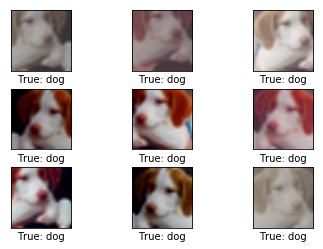

In [53]:
plot_distorted_image(img, cls)

## Perform optimization

In [56]:
# if False:
optimize(num_iterations=1000)

Global Step:    200, Training Batch Accuracy:  20.3%, Loss: 63.9046
Global Step:    300, Training Batch Accuracy:  32.8%, Loss: 13.5386
Global Step:    400, Training Batch Accuracy:  29.7%, Loss: 14.6684
Global Step:    500, Training Batch Accuracy:  20.3%, Loss: 18.6808
Global Step:    600, Training Batch Accuracy:  25.0%, Loss: 17.7031
Global Step:    700, Training Batch Accuracy:  23.4%, Loss: 22.7563
Global Step:    800, Training Batch Accuracy:  25.0%, Loss: 8.7594
Global Step:    900, Training Batch Accuracy:  20.3%, Loss: 12.3597
Global Step:   1000, Training Batch Accuracy:  34.4%, Loss: 8.1395
Saved checkpoint.
Global Step:   1100, Training Batch Accuracy:  32.8%, Loss: 8.6340
Saved checkpoint.
Time usage: 0:03:04


In [57]:
# if False:
optimize(num_iterations=50000)

Global Step:   1200, Training Batch Accuracy:  28.1%, Loss: 9.5486
Global Step:   1300, Training Batch Accuracy:  29.7%, Loss: 8.2752
Global Step:   1400, Training Batch Accuracy:  28.1%, Loss: 8.4847
Global Step:   1500, Training Batch Accuracy:  39.1%, Loss: 5.0125
Global Step:   1600, Training Batch Accuracy:  25.0%, Loss: 7.1556
Global Step:   1700, Training Batch Accuracy:  25.0%, Loss: 7.4629
Global Step:   1800, Training Batch Accuracy:  34.4%, Loss: 5.2196
Global Step:   1900, Training Batch Accuracy:  20.3%, Loss: 6.4181
Global Step:   2000, Training Batch Accuracy:  31.2%, Loss: 6.1789
Saved checkpoint.
Global Step:   2100, Training Batch Accuracy:  26.6%, Loss: 5.7046
Global Step:   2200, Training Batch Accuracy:  25.0%, Loss: 5.3824
Global Step:   2300, Training Batch Accuracy:  29.7%, Loss: 3.5059
Global Step:   2400, Training Batch Accuracy:  28.1%, Loss: 4.5926
Global Step:   2500, Training Batch Accuracy:  31.2%, Loss: 3.9082
Global Step:   2600, Training Batch Accuracy

Global Step:  13200, Training Batch Accuracy:  42.2%, Loss: 1.7590
Global Step:  13300, Training Batch Accuracy:  43.8%, Loss: 1.7471
Global Step:  13400, Training Batch Accuracy:  40.6%, Loss: 1.6087
Global Step:  13500, Training Batch Accuracy:  40.6%, Loss: 1.6872
Global Step:  13600, Training Batch Accuracy:  45.3%, Loss: 1.5508
Global Step:  13700, Training Batch Accuracy:  42.2%, Loss: 1.6681
Global Step:  13800, Training Batch Accuracy:  40.6%, Loss: 1.5554
Global Step:  13900, Training Batch Accuracy:  51.6%, Loss: 1.4095
Global Step:  14000, Training Batch Accuracy:  46.9%, Loss: 1.5517
Saved checkpoint.
Global Step:  14100, Training Batch Accuracy:  50.0%, Loss: 1.5817
Global Step:  14200, Training Batch Accuracy:  50.0%, Loss: 1.3750
Global Step:  14300, Training Batch Accuracy:  45.3%, Loss: 1.4364
Global Step:  14400, Training Batch Accuracy:  43.8%, Loss: 1.3788
Global Step:  14500, Training Batch Accuracy:  46.9%, Loss: 1.4447
Global Step:  14600, Training Batch Accuracy

Global Step:  25200, Training Batch Accuracy:  56.2%, Loss: 1.2326
Global Step:  25300, Training Batch Accuracy:  59.4%, Loss: 1.1604
Global Step:  25400, Training Batch Accuracy:  59.4%, Loss: 1.1320
Global Step:  25500, Training Batch Accuracy:  56.2%, Loss: 1.1873
Global Step:  25600, Training Batch Accuracy:  59.4%, Loss: 1.3659
Global Step:  25700, Training Batch Accuracy:  67.2%, Loss: 0.9407
Global Step:  25800, Training Batch Accuracy:  54.7%, Loss: 1.3687
Global Step:  25900, Training Batch Accuracy:  65.6%, Loss: 1.0879
Global Step:  26000, Training Batch Accuracy:  57.8%, Loss: 1.2697
Saved checkpoint.
Global Step:  26100, Training Batch Accuracy:  59.4%, Loss: 1.4141
Global Step:  26200, Training Batch Accuracy:  65.6%, Loss: 1.0877
Global Step:  26300, Training Batch Accuracy:  57.8%, Loss: 1.1281
Global Step:  26400, Training Batch Accuracy:  50.0%, Loss: 1.4593
Global Step:  26500, Training Batch Accuracy:  59.4%, Loss: 1.0912
Global Step:  26600, Training Batch Accuracy

Global Step:  37200, Training Batch Accuracy:  70.3%, Loss: 0.9153
Global Step:  37300, Training Batch Accuracy:  62.5%, Loss: 1.1602
Global Step:  37400, Training Batch Accuracy:  62.5%, Loss: 1.2498
Global Step:  37500, Training Batch Accuracy:  65.6%, Loss: 0.8338
Global Step:  37600, Training Batch Accuracy:  60.9%, Loss: 1.1223
Global Step:  37700, Training Batch Accuracy:  71.9%, Loss: 0.8345
Global Step:  37800, Training Batch Accuracy:  59.4%, Loss: 1.1521
Global Step:  37900, Training Batch Accuracy:  60.9%, Loss: 1.0431
Global Step:  38000, Training Batch Accuracy:  57.8%, Loss: 1.2491
Saved checkpoint.
Global Step:  38100, Training Batch Accuracy:  71.9%, Loss: 0.8476
Global Step:  38200, Training Batch Accuracy:  67.2%, Loss: 0.9722
Global Step:  38300, Training Batch Accuracy:  65.6%, Loss: 0.9004
Global Step:  38400, Training Batch Accuracy:  62.5%, Loss: 1.0598
Global Step:  38500, Training Batch Accuracy:  81.2%, Loss: 0.6310
Global Step:  38600, Training Batch Accuracy

Global Step:  49200, Training Batch Accuracy:  71.9%, Loss: 0.7496
Global Step:  49300, Training Batch Accuracy:  75.0%, Loss: 0.7421
Global Step:  49400, Training Batch Accuracy:  65.6%, Loss: 1.0497
Global Step:  49500, Training Batch Accuracy:  68.8%, Loss: 0.6466
Global Step:  49600, Training Batch Accuracy:  76.6%, Loss: 0.6456
Global Step:  49700, Training Batch Accuracy:  76.6%, Loss: 0.7215
Global Step:  49800, Training Batch Accuracy:  81.2%, Loss: 0.6029
Global Step:  49900, Training Batch Accuracy:  62.5%, Loss: 1.0125
Global Step:  50000, Training Batch Accuracy:  75.0%, Loss: 0.7788
Saved checkpoint.
Global Step:  50100, Training Batch Accuracy:  60.9%, Loss: 1.0230
Global Step:  50200, Training Batch Accuracy:  75.0%, Loss: 0.7517
Global Step:  50300, Training Batch Accuracy:  65.6%, Loss: 0.9159
Global Step:  50400, Training Batch Accuracy:  56.2%, Loss: 1.2332
Global Step:  50500, Training Batch Accuracy:  70.3%, Loss: 0.8175
Global Step:  50600, Training Batch Accuracy

Accuracy on Test-Set: 66.0% (6603 / 10000)
Example errors:


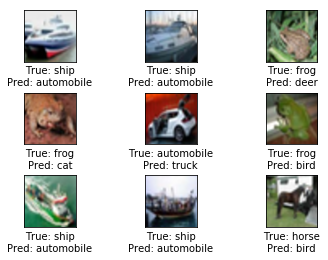

Confusion Matrix:
[763  44  68  14  14   3   6  15  38  35] (0) airplane
[ 28 861  13   7   7   7   4   3  10  60] (1) automobile
[ 89  10 627  60  65  40  48  36   8  17] (2) bird
[ 36  25 110 463  60 158  42  62  11  33] (3) cat
[ 46  15 114  53 545  41  46 117   6  17] (4) deer
[ 23  10  84 187  55 536  20  67   1  17] (5) dog
[ 20  21  84  83  57  37 659  12   6  21] (6) frog
[ 31   6  51  57  52  50   8 708   2  35] (7) horse
[124  79  21  16   6   6   4   4 691  49] (8) ship
[ 51 123   9   9  12   7   4  16  19 750] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [58]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

In [59]:
# if False:
optimize(num_iterations=50000)

Global Step:  51200, Training Batch Accuracy:  82.8%, Loss: 0.5912
Global Step:  51300, Training Batch Accuracy:  54.7%, Loss: 1.2416
Global Step:  51400, Training Batch Accuracy:  65.6%, Loss: 1.0378
Global Step:  51500, Training Batch Accuracy:  70.3%, Loss: 0.9182
Global Step:  51600, Training Batch Accuracy:  68.8%, Loss: 0.9977
Global Step:  51700, Training Batch Accuracy:  73.4%, Loss: 0.7960
Global Step:  51800, Training Batch Accuracy:  67.2%, Loss: 0.8604
Global Step:  51900, Training Batch Accuracy:  68.8%, Loss: 0.7661
Global Step:  52000, Training Batch Accuracy:  71.9%, Loss: 0.8421
Saved checkpoint.
Global Step:  52100, Training Batch Accuracy:  64.1%, Loss: 0.9646
Global Step:  52200, Training Batch Accuracy:  70.3%, Loss: 0.7672
Global Step:  52300, Training Batch Accuracy:  68.8%, Loss: 0.9850
Global Step:  52400, Training Batch Accuracy:  76.6%, Loss: 0.6986
Global Step:  52500, Training Batch Accuracy:  73.4%, Loss: 0.7199
Global Step:  52600, Training Batch Accuracy

Global Step:  63200, Training Batch Accuracy:  75.0%, Loss: 0.7803
Global Step:  63300, Training Batch Accuracy:  78.1%, Loss: 0.6921
Global Step:  63400, Training Batch Accuracy:  78.1%, Loss: 0.6959
Global Step:  63500, Training Batch Accuracy:  75.0%, Loss: 0.8269
Global Step:  63600, Training Batch Accuracy:  70.3%, Loss: 0.8364
Global Step:  63700, Training Batch Accuracy:  71.9%, Loss: 0.6898
Global Step:  63800, Training Batch Accuracy:  67.2%, Loss: 0.8881
Global Step:  63900, Training Batch Accuracy:  73.4%, Loss: 0.7141
Global Step:  64000, Training Batch Accuracy:  81.2%, Loss: 0.5777
Saved checkpoint.
Global Step:  64100, Training Batch Accuracy:  78.1%, Loss: 0.6673
Global Step:  64200, Training Batch Accuracy:  71.9%, Loss: 0.8204
Global Step:  64300, Training Batch Accuracy:  70.3%, Loss: 0.7634
Global Step:  64400, Training Batch Accuracy:  81.2%, Loss: 0.5454
Global Step:  64500, Training Batch Accuracy:  71.9%, Loss: 0.6918
Global Step:  64600, Training Batch Accuracy

Global Step:  75200, Training Batch Accuracy:  81.2%, Loss: 0.5398
Global Step:  75300, Training Batch Accuracy:  75.0%, Loss: 0.6819
Global Step:  75400, Training Batch Accuracy:  89.1%, Loss: 0.4241
Global Step:  75500, Training Batch Accuracy:  73.4%, Loss: 0.7379
Global Step:  75600, Training Batch Accuracy:  76.6%, Loss: 0.8207
Global Step:  75700, Training Batch Accuracy:  76.6%, Loss: 0.7623
Global Step:  75800, Training Batch Accuracy:  84.4%, Loss: 0.4560
Global Step:  75900, Training Batch Accuracy:  85.9%, Loss: 0.5000
Global Step:  76000, Training Batch Accuracy:  81.2%, Loss: 0.5830
Saved checkpoint.
Global Step:  76100, Training Batch Accuracy:  79.7%, Loss: 0.6402
Global Step:  76200, Training Batch Accuracy:  76.6%, Loss: 0.7936
Global Step:  76300, Training Batch Accuracy:  81.2%, Loss: 0.4290
Global Step:  76400, Training Batch Accuracy:  64.1%, Loss: 0.9252
Global Step:  76500, Training Batch Accuracy:  90.6%, Loss: 0.4225
Global Step:  76600, Training Batch Accuracy

Global Step:  87200, Training Batch Accuracy:  82.8%, Loss: 0.4682
Global Step:  87300, Training Batch Accuracy:  82.8%, Loss: 0.5874
Global Step:  87400, Training Batch Accuracy:  85.9%, Loss: 0.4991
Global Step:  87500, Training Batch Accuracy:  82.8%, Loss: 0.5256
Global Step:  87600, Training Batch Accuracy:  82.8%, Loss: 0.5354
Global Step:  87700, Training Batch Accuracy:  70.3%, Loss: 0.7490
Global Step:  87800, Training Batch Accuracy:  68.8%, Loss: 0.7779
Global Step:  87900, Training Batch Accuracy:  75.0%, Loss: 0.5725
Global Step:  88000, Training Batch Accuracy:  78.1%, Loss: 0.7066
Saved checkpoint.
Global Step:  88100, Training Batch Accuracy:  82.8%, Loss: 0.5147
Global Step:  88200, Training Batch Accuracy:  76.6%, Loss: 0.5810
Global Step:  88300, Training Batch Accuracy:  76.6%, Loss: 0.7118
Global Step:  88400, Training Batch Accuracy:  79.7%, Loss: 0.5692
Global Step:  88500, Training Batch Accuracy:  84.4%, Loss: 0.5186
Global Step:  88600, Training Batch Accuracy

Global Step:  99200, Training Batch Accuracy:  79.7%, Loss: 0.5825
Global Step:  99300, Training Batch Accuracy:  84.4%, Loss: 0.4554
Global Step:  99400, Training Batch Accuracy:  76.6%, Loss: 0.5085
Global Step:  99500, Training Batch Accuracy:  92.2%, Loss: 0.2550
Global Step:  99600, Training Batch Accuracy:  81.2%, Loss: 0.5251
Global Step:  99700, Training Batch Accuracy:  84.4%, Loss: 0.5369
Global Step:  99800, Training Batch Accuracy:  82.8%, Loss: 0.5211
Global Step:  99900, Training Batch Accuracy:  81.2%, Loss: 0.4645
Global Step: 100000, Training Batch Accuracy:  81.2%, Loss: 0.4875
Saved checkpoint.
Global Step: 100100, Training Batch Accuracy:  85.9%, Loss: 0.3828
Global Step: 100200, Training Batch Accuracy:  84.4%, Loss: 0.5277
Global Step: 100300, Training Batch Accuracy:  82.8%, Loss: 0.5129
Global Step: 100400, Training Batch Accuracy:  79.7%, Loss: 0.4888
Global Step: 100500, Training Batch Accuracy:  90.6%, Loss: 0.4056
Global Step: 100600, Training Batch Accuracy

Accuracy on Test-Set: 73.5% (7353 / 10000)
Example errors:


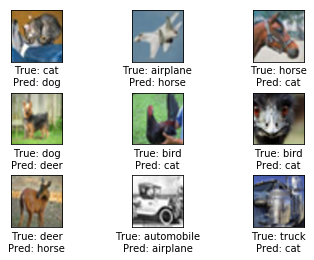

Confusion Matrix:
[795  23  49  22  15   6   6  18  43  23] (0) airplane
[ 18 875  15  12  13   4  10   4  19  30] (1) automobile
[ 44   5 678  66  57  45  52  35  12   6] (2) bird
[ 20   5  76 611  65  98  58  53  12   2] (3) cat
[ 17   3  80  54 680  24  70  62   8   2] (4) deer
[ 12   4  62 204  40 575  32  63   2   6] (5) dog
[ 11   3  53  63  29  19 797  12  11   2] (6) frog
[  7   2  33  42  57  35  12 802   2   8] (7) horse
[ 65  39  24  21  15   4   2   6 797  27] (8) ship
[ 24  82  15  24  18   9  18  30  37 743] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [60]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

In [61]:
# if False:
optimize(num_iterations=50000)

Global Step: 101200, Training Batch Accuracy:  89.1%, Loss: 0.4128
Global Step: 101300, Training Batch Accuracy:  82.8%, Loss: 0.4591
Global Step: 101400, Training Batch Accuracy:  79.7%, Loss: 0.4881
Global Step: 101500, Training Batch Accuracy:  81.2%, Loss: 0.4649
Global Step: 101600, Training Batch Accuracy:  82.8%, Loss: 0.5059
Global Step: 101700, Training Batch Accuracy:  73.4%, Loss: 0.7478
Global Step: 101800, Training Batch Accuracy:  82.8%, Loss: 0.5143
Global Step: 101900, Training Batch Accuracy:  85.9%, Loss: 0.5333
Global Step: 102000, Training Batch Accuracy:  85.9%, Loss: 0.5922
Saved checkpoint.
Global Step: 102100, Training Batch Accuracy:  92.2%, Loss: 0.2200
Global Step: 102200, Training Batch Accuracy:  81.2%, Loss: 0.5913
Global Step: 102300, Training Batch Accuracy:  81.2%, Loss: 0.4109
Global Step: 102400, Training Batch Accuracy:  82.8%, Loss: 0.4737
Global Step: 102500, Training Batch Accuracy:  78.1%, Loss: 0.6700
Global Step: 102600, Training Batch Accuracy

Global Step: 113200, Training Batch Accuracy:  89.1%, Loss: 0.3979
Global Step: 113300, Training Batch Accuracy:  84.4%, Loss: 0.3215
Global Step: 113400, Training Batch Accuracy:  82.8%, Loss: 0.4675
Global Step: 113500, Training Batch Accuracy:  89.1%, Loss: 0.3810
Global Step: 113600, Training Batch Accuracy:  81.2%, Loss: 0.4973
Global Step: 113700, Training Batch Accuracy:  85.9%, Loss: 0.4237
Global Step: 113800, Training Batch Accuracy:  78.1%, Loss: 0.7617
Global Step: 113900, Training Batch Accuracy:  82.8%, Loss: 0.4627
Global Step: 114000, Training Batch Accuracy:  96.9%, Loss: 0.1668
Saved checkpoint.
Global Step: 114100, Training Batch Accuracy:  89.1%, Loss: 0.4004
Global Step: 114200, Training Batch Accuracy:  85.9%, Loss: 0.4720
Global Step: 114300, Training Batch Accuracy:  81.2%, Loss: 0.4788
Global Step: 114400, Training Batch Accuracy:  87.5%, Loss: 0.3619
Global Step: 114500, Training Batch Accuracy:  92.2%, Loss: 0.3337
Global Step: 114600, Training Batch Accuracy

Global Step: 125200, Training Batch Accuracy:  84.4%, Loss: 0.4790
Global Step: 125300, Training Batch Accuracy:  82.8%, Loss: 0.5188
Global Step: 125400, Training Batch Accuracy:  90.6%, Loss: 0.3700
Global Step: 125500, Training Batch Accuracy:  89.1%, Loss: 0.3152
Global Step: 125600, Training Batch Accuracy:  89.1%, Loss: 0.2542
Global Step: 125700, Training Batch Accuracy:  82.8%, Loss: 0.4976
Global Step: 125800, Training Batch Accuracy:  84.4%, Loss: 0.3638
Global Step: 125900, Training Batch Accuracy:  89.1%, Loss: 0.3684
Global Step: 126000, Training Batch Accuracy:  81.2%, Loss: 0.4446
Saved checkpoint.
Global Step: 126100, Training Batch Accuracy:  89.1%, Loss: 0.3094
Global Step: 126200, Training Batch Accuracy:  87.5%, Loss: 0.3990
Global Step: 126300, Training Batch Accuracy:  79.7%, Loss: 0.5699
Global Step: 126400, Training Batch Accuracy:  89.1%, Loss: 0.4122
Global Step: 126500, Training Batch Accuracy:  89.1%, Loss: 0.4908
Global Step: 126600, Training Batch Accuracy

Global Step: 137200, Training Batch Accuracy:  90.6%, Loss: 0.2837
Global Step: 137300, Training Batch Accuracy:  92.2%, Loss: 0.2321
Global Step: 137400, Training Batch Accuracy:  84.4%, Loss: 0.4212
Global Step: 137500, Training Batch Accuracy:  90.6%, Loss: 0.3017
Global Step: 137600, Training Batch Accuracy:  84.4%, Loss: 0.3643
Global Step: 137700, Training Batch Accuracy:  85.9%, Loss: 0.3960
Global Step: 137800, Training Batch Accuracy:  89.1%, Loss: 0.4112
Global Step: 137900, Training Batch Accuracy:  89.1%, Loss: 0.4099
Global Step: 138000, Training Batch Accuracy:  84.4%, Loss: 0.4315
Saved checkpoint.
Global Step: 138100, Training Batch Accuracy:  82.8%, Loss: 0.4594
Global Step: 138200, Training Batch Accuracy:  82.8%, Loss: 0.5425
Global Step: 138300, Training Batch Accuracy:  93.8%, Loss: 0.2250
Global Step: 138400, Training Batch Accuracy:  79.7%, Loss: 0.4395
Global Step: 138500, Training Batch Accuracy:  93.8%, Loss: 0.2172
Global Step: 138600, Training Batch Accuracy

Global Step: 149200, Training Batch Accuracy:  89.1%, Loss: 0.3242
Global Step: 149300, Training Batch Accuracy:  79.7%, Loss: 0.6330
Global Step: 149400, Training Batch Accuracy:  84.4%, Loss: 0.3484
Global Step: 149500, Training Batch Accuracy:  90.6%, Loss: 0.3179
Global Step: 149600, Training Batch Accuracy:  92.2%, Loss: 0.2153
Global Step: 149700, Training Batch Accuracy:  85.9%, Loss: 0.3523
Global Step: 149800, Training Batch Accuracy:  82.8%, Loss: 0.5335
Global Step: 149900, Training Batch Accuracy:  87.5%, Loss: 0.2869
Global Step: 150000, Training Batch Accuracy:  84.4%, Loss: 0.3999
Saved checkpoint.
Global Step: 150100, Training Batch Accuracy:  84.4%, Loss: 0.3724
Global Step: 150200, Training Batch Accuracy:  89.1%, Loss: 0.3660
Global Step: 150300, Training Batch Accuracy:  96.9%, Loss: 0.1991
Global Step: 150400, Training Batch Accuracy:  89.1%, Loss: 0.3834
Global Step: 150500, Training Batch Accuracy:  89.1%, Loss: 0.2831
Global Step: 150600, Training Batch Accuracy

Accuracy on Test-Set: 75.0% (7498 / 10000)
Example errors:


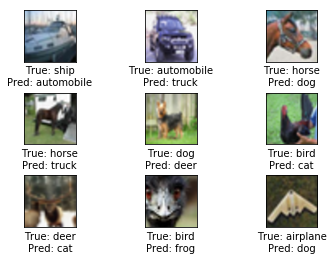

Confusion Matrix:
[804   7  36  27  13   6  15  10  48  34] (0) airplane
[ 31 843  11  15   4   3  11   4  19  59] (1) automobile
[ 47   2 683  75  57  42  54  20  11   9] (2) bird
[ 24   5  65 583  48 166  58  29   5  17] (3) cat
[ 15   4  67  64 680  70  50  42   5   3] (4) deer
[  7   0  46 171  36 666  23  42   3   6] (5) dog
[  8   4  42  63  21  22 831   4   1   4] (6) frog
[ 15   4  28  54  54  54  11 761   3  16] (7) horse
[ 53  19  13  26   7   7  15   6 823  31] (8) ship
[ 24  37  10  37   5  13  12  10  28 824] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [62]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## Results

Examples of mis-classifications are plotted below. Some of these are difficult to recognize even for humans and others are reasonable mistakes e.g. between a large car and a truck, or between a cat and a dog, while other mistakes seem a bit strange.

Accuracy on Test-Set: 74.7% (7472 / 10000)
Example errors:


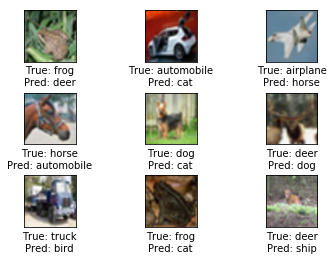

Confusion Matrix:
[792  13  44  27  16   4  13  12  52  27] (0) airplane
[ 22 846  11  16   6   4  10   2  22  61] (1) automobile
[ 51   3 673  86  58  35  55  24  10   5] (2) bird
[ 19   8  69 586  50 161  57  30   8  12] (3) cat
[ 10   1  73  65 693  65  41  43   5   4] (4) deer
[ 12   5  45 173  29 654  24  45   5   8] (5) dog
[  6   6  44  66  27  22 818   3   4   4] (6) frog
[  9   3  31  57  48  59   9 771   2  11] (7) horse
[ 57  29  14  23   5  13  10   4 823  22] (8) ship
[ 33  37  14  23   7  14  11  19  26 816] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [63]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

### Convolutional Weights

The following shows some of the weights (or filters) for the first convolutional layer. There are 3 input channels so there are 3 of these sets, which you may plot by changing the `input_channel`.

Note that positive weights are red and negative weights are blue.

In [65]:
#plot_conv_weights(weights=weights_conv1, input_channel=0)

Plot some of the weights (or filters) for the second convolutional layer. These are apparently closer to zero than the weights for the first convolutional layers, see the lower standard deviation.

In [66]:
#plot_conv_weights(weights=weights_conv2, input_channel=1)

### Output of convolutional layers

Helper-function for plotting an image.

In [67]:
def plot_image(image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 2)

    # References to the sub-plots.
    ax0 = axes.flat[0]
    ax1 = axes.flat[1]

    # Show raw and smoothened images in sub-plots.
    ax0.imshow(image, interpolation='nearest')
    ax1.imshow(image, interpolation='spline16')

    # Set labels.
    ax0.set_xlabel('Raw')
    ax1.set_xlabel('Smooth')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Plot an image from the test-set. The raw pixelated image is used as input to the neural network.

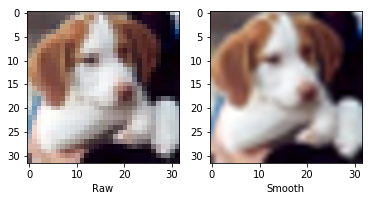

In [68]:
img, cls = get_test_image(16)
plot_image(img)

Use the raw image as input to the neural network and plot the output of the first convolutional layer.

In [ ]:
plot_layer_output(output_conv1, image=img)

Using the same image as input to the neural network, now plot the output of the second convolutional layer.

In [69]:
#plot_layer_output(output_conv2, image=img)

### Predicted class-labels

Get the predicted class-label and class-number for this image.

In [70]:
label_pred, cls_pred = session.run([y_pred, y_pred_cls],
                                   feed_dict={x: [img]})

Print the predicted class-label.

In [71]:
# Set the rounding options for numpy.
np.set_printoptions(precision=3, suppress=True)

# Print the predicted label.
print(label_pred[0])

[ 0.     0.     0.     0.003  0.     0.996  0.     0.001  0.     0.   ]


The predicted class-label is an array of length 10, with each element indicating how confident the neural network is that the image is the given class.

In this case the element with index 3 has a value of 0.493, while the element with index 5 has a value of 0.490. This means the neural network believes the image either shows a class 3 or class 5, which is a cat or a dog, respectively.

In [72]:
class_names[3]

'cat'

In [73]:
class_names[5]

'dog'

## Close TensorFlow Session

We are now done using TensorFlow, so we close the session to release its resources.

In [ ]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()

## Homework

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Run the optimization for 100,000 iterations and see what the classification accuracy is. This will create a checkpoint that saves all the variables of the TensorFlow graph.
* Try changing the structure of the neural network to AlexNet. How does it affect the training time and the classification accuracy? Note that the checkpoints cannot be reloaded when you change the structure of the neural network.